In [1]:
!wget http://d28rh4a8wq0iu5.cloudfront.net/ads1/data/phix.fa

--2015-07-14 11:55:06--  http://d28rh4a8wq0iu5.cloudfront.net/ads1/data/phix.fa
Resolving d28rh4a8wq0iu5.cloudfront.net... 54.230.53.87, 54.192.54.164, 54.192.54.222, ...
Connecting to d28rh4a8wq0iu5.cloudfront.net|54.230.53.87|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5528 (5.4K) [application/octet-stream]
Saving to: 'phix.fa'

phix.fa             100%[=====================>]   5.40K  --.-KB/s   in 0.003s 

2015-07-14 11:55:07 (1.60 MB/s) - 'phix.fa' saved [5528/5528]



In [4]:
def readGenome(filename):
    genome = ''
    with open(filename, 'r') as f:
        for line in f:
            # ignore header line with genome information
            if not line[0] == '>':
                genome += line.rstrip()
    return genome

In [5]:
genome = readGenome('phix.fa')

In [6]:
def naive(p, t):
    occurrences = []
    for i in range(len(t) - len(p) + 1):
        match = True
        for j in range(len(p)):
            if t[i+j] != p[j]:
                match = False
                break
        if match:
            occurrences.append(i)
    return occurrences

In [7]:
t = 'AGCTTAGATAGC'
p = 'AG'
naive(p, t)

[0, 5, 9]

In [8]:
import random
def generateReads(genome, numReads, readLen):
    ''' Generate reads from random positions in the given genome. '''
    reads = []
    for _ in range(numReads):
        start = random.randint(0, len(genome)-readLen) - 1
        reads.append(genome[start : start+readLen])
    return reads

In [9]:
# Generate 100 reads of length 100
reads = generateReads(genome, 100, 100)

# Count how many reads match the genome exactly
numMatched = 0
for r in reads:
    matches = naive(r, genome)
    if len(matches) > 0:
        numMatched += 1
print('%d / %d reads matched the genome exactly!' % (numMatched, len(reads)))

100 / 100 reads matched the genome exactly!


In [1]:
!wget http://d28rh4a8wq0iu5.cloudfront.net/ads1/data/ERR266411_1.first1000.fastq

--2018-03-21 12:33:44--  http://d28rh4a8wq0iu5.cloudfront.net/ads1/data/ERR266411_1.first1000.fastq
Resolving d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)... 52.84.206.23, 52.84.206.80, 52.84.206.233, ...
Connecting to d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)|52.84.206.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254384 (248K) [audio/mpeg]
Saving to: ‘ERR266411_1.first1000.fastq’

ERR266411_1.first10 100%[===================>] 248.42K   162KB/s    in 1.5s    

2018-03-21 12:33:46 (162 KB/s) - ‘ERR266411_1.first1000.fastq’ saved [254384/254384]



In [58]:
def readFastq(filename):
    sequences = []
    with open(filename) as fh:
        while True:
            fh.readline() # skip name line
            seq = fh.readline().rstrip() # read base sequence
            fh.readline() # skip placeholder line
            fh.readline() # skip base quality line
            if len(seq) == 0:
                break
            sequences.append(seq)
    return sequences

In [11]:
import collections
phix_reads = readFastq('ERR266411_1.first1000.fastq')
count = collections.Counter()
for read in phix_reads:
    count.update(read)
count

Counter({'A': 28426, 'C': 21890, 'G': 19147, 'N': 6, 'T': 30531})

In [12]:
numMatched = 0
n = 0
for r in phix_reads:
    matches = naive(r, genome)
    n += 1
    if len(matches) > 0:
        numMatched += 1
print('%d / %d reads matched the genome exactly!' % (numMatched, n))

7 / 1000 reads matched the genome exactly!


In [13]:
# Now let's try matching just the first 30 bases of each read
numMatched = 0
n = 0
for r in phix_reads:
    r = r[:30]  # just taking the first 30 bases
    matches = naive(r, genome)
    n += 1
    if len(matches) > 0:
        numMatched += 1
print('%d / %d reads matched the genome exactly!' % (numMatched, n))

459 / 1000 reads matched the genome exactly!


In [14]:
def reverseComplement(s):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'N': 'N'}
    t = ''
    for base in s:
        t = complement[base] + t
    return t

In [15]:
numMatched = 0
n = 0
for r in phix_reads:
    r = r[:30]  # just taking the first 30 bases
    matches = naive(r, genome)
    matches.extend(naive(reverseComplement(r), genome))
    n += 1
    if len(matches) > 0:
        numMatched += 1
print('%d / %d reads matched the genome exactly!' % (numMatched, n))

932 / 1000 reads matched the genome exactly!


In [16]:
reverseComplement('AACGTT')

'AACGTT'

## week 1 programming assignment

First, implement a version of the naive exact matching algorithm that is strand-aware. That is, instead of looking only for occurrences of P in T, additionally look for occurrences of the reverse complement of P in T. If P is ACT, your function should find occurrences of both ACTand its reverse complement AGT in T.

If P and its reverse complement are identical (e.g. AACGTT), then a given match offset should be reported only once. So if your new function is called naive_with_rc, then the old naive function and your new naive_with_rc function should return the same results when P equals its reverse complement.

In [18]:
def naive_with_rc(p, t):
    occurrences = []
    rc = reverseComplement(p)
    for i in range(len(t) - len(p) + 1):
        match = True
        for j in range(len(p)):
            if t[i+j] != p[j]:
                match = False
                break
        if rc != p and not match:
            match = True
            for j in range(len(rc)):
                if t[i+j] != rc[j]:
                    match = False
                    break
        if match:
            occurrences.append(i)
    return occurrences

validations

In [21]:
p = 'CCC'
ten_as = 'AAAAAAAAAA'
t = ten_as + 'CCC' + ten_as + 'GGG' + ten_as
occurrences = naive_with_rc(p, t)
print(occurrences)

p = 'CGCG'
t = ten_as + 'CGCG' + ten_as + 'CGCG' + ten_as
occurrences = naive_with_rc(p, t)
print(occurrences)

phix_genome = readGenome('phix.fa')
occurrences = naive_with_rc('ATTA', phix_genome)
print('offset of leftmost occurrence: %d' % min(occurrences))
print('# occurrences: %d' % len(occurrences))

[10, 23]
[10, 24]
offset of leftmost occurrence: 62
# occurrences: 60


Next, download and parse the lambda virus genome

In [51]:
lvgenome = readGenome('lambda_virus.fa')

In [43]:
matches = naive_with_rc('AGTCGA', lvgenome)

In [32]:
print('pattern %s and its RC matched the lambda virus genome %d times' % ('AGGT', len(matches)))

pattern AGGT and its RC matched the lambda virus genome 306 times


In [35]:
print('pattern %s and its RC matched the lambda virus genome %d times' % ('TTAA', len(matches)))

pattern TTAA and its RC matched the lambda virus genome 195 times


In [39]:
print('pattern %s offset of leftmost occurrence: %d' % ('ACTAAGT', min(matches)))

pattern ACTAAGT offset of leftmost occurrence: 26028


In [44]:
print('pattern %s offset of leftmost occurrence: %d' % ('AGTCGA', min(matches)))

pattern AGTCGA offset of leftmost occurrence: 450


In [49]:
# Implement the naive_2mm function
def naive_2mm(p, t):
    occurrences = []
    for i in range(len(t) - len(p) + 1):
        match = True
        mismatches = 0
        for j in range(len(p)):
            if t[i+j] != p[j] and mismatches == 2:
                match = False
                break
            elif t[i+j] != p[j]: 
                mismatches += 1
        if match:
            occurrences.append(i)
    return occurrences

validations

In [50]:
p = 'CTGT'
ten_as = 'AAAAAAAAAA'
t = ten_as + 'CTGT' + ten_as + 'CTTT' + ten_as + 'CGGG' + ten_as
occurrences = naive_2mm(p, t)
print(occurrences)

phix_genome = readGenome('phix.fa')
occurrences = naive_2mm('GATTACA', phix_genome)
print('offset of leftmost occurrence: %d' % min(occurrences))
print('# occurrences: %d' % len(occurrences))

[10, 24, 38]
offset of leftmost occurrence: 10
# occurrences: 79


In [55]:
matches = naive_2mm('AGGAGGTT', lvgenome)

In [53]:
print('pattern %s matched the lambda virus genome %d times' % ('TTCAAGCC', len(matches)))

pattern TTCAAGCC matched the lambda virus genome 191 times


In [56]:
print('pattern %s offset of leftmost occurrence: %d' % ('AGGAGGTT', min(matches)))

pattern AGGAGGTT offset of leftmost occurrence: 49


In [57]:
!wget https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/ERR037900_1.first1000.fastq

--2018-03-21 17:38:38--  https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/ERR037900_1.first1000.fastq
Resolving d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)... 52.84.206.145, 52.84.206.80, 52.84.206.227, ...
Connecting to d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)|52.84.206.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 241626 (236K) [application/octet-stream]
Saving to: ‘ERR037900_1.first1000.fastq’

ERR037900_1.first10 100%[===================>] 235.96K   167KB/s    in 1.4s    

2018-03-21 17:38:41 (167 KB/s) - ‘ERR037900_1.first1000.fastq’ saved [241626/241626]



In [61]:
def readFastq(filename):
    sequences = []
    qualities = []
    with open(filename) as fh:
        while True:
            fh.readline() # skip name line
            seq = fh.readline().rstrip() # read base sequence
            fh.readline() # skip placeholder line
            qual = fh.readline().rstrip() #base quality line
            if len(seq) == 0:
                break
            sequences.append(seq)
            qualities.append(qual)
    return sequences, qualities

In [62]:
import collections
phix2_reads, phix2_qualities = readFastq('ERR037900_1.first1000.fastq')
count = collections.Counter()
for read in phix2_reads:
    count.update(read)
count

Counter({'A': 24057, 'C': 29665, 'G': 22888, 'N': 914, 'T': 22476})

In [63]:
def phred33ToQ(qual):
    return ord(qual) - 33

In [67]:
phred33ToQ('#')

2

In [68]:
def createHist(qualities):
    # Create a histogram of quality scores
    hist = [0]*50
    for qual in qualities:
        for phred in qual:
            q = phred33ToQ(phred)
            hist[q] += 1
    return hist
h = createHist(phix2_qualities)
print(h)

[0, 0, 17723, 0, 2, 11, 11, 28, 23, 55, 100, 111, 86, 174, 185, 272, 317, 259, 390, 1523, 2782, 762, 286, 413, 403, 538, 351, 694, 971, 777, 1024, 1449, 1341, 1312, 1916, 2233, 3025, 4043, 6640, 45696, 2074, 0, 0, 0, 0, 0, 0, 0, 0, 0]


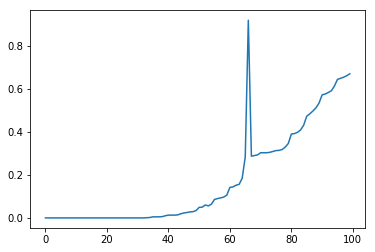

In [70]:
#function to fish the distributions of thread offsets where the hash (#) quality is reported
#to answer question 7 of the programming assignment
%matplotlib inline
import matplotlib.pyplot as plt
def findHashByPos(qualities):
    ''' Find the # ratio at each position in the read '''
    # Keep track of the number of G/C bases and the total number of bases at each position
    hashqual = [0] * 100
    totals = [0] * 100
    for read in qualities:
        for i in range(len(read)):
            if read[i] == '#':
                hashqual[i] += 1
            totals[i] += 1
    # Divide # counts by total counts to get the average at each position
    for i in range(len(hashqual)):
        if totals[i] > 0:
            hashqual[i] /= float(totals[i])
    return hashqual

hashqual = findHashByPos(phix2_qualities)
plt.plot(range(len(hashqual)), hashqual)
plt.show()

In [71]:
for i in range(len(hashqual)):
    print str(i)+": "+str(hashqual[i])

0: 0.0
1: 0.0
2: 0.0
3: 0.0
4: 0.0
5: 0.0
6: 0.0
7: 0.0
8: 0.0
9: 0.0
10: 0.0
11: 0.0
12: 0.0
13: 0.0
14: 0.0
15: 0.0
16: 0.0
17: 0.0
18: 0.0
19: 0.0
20: 0.0
21: 0.0
22: 0.0
23: 0.0
24: 0.0
25: 0.0
26: 0.0
27: 0.0
28: 0.0
29: 0.0
30: 0.0
31: 0.0
32: 0.0
33: 0.001
34: 0.002
35: 0.005
36: 0.005
37: 0.005
38: 0.006
39: 0.01
40: 0.013
41: 0.013
42: 0.013
43: 0.014
44: 0.019
45: 0.023
46: 0.025
47: 0.028
48: 0.029
49: 0.034
50: 0.049
51: 0.05
52: 0.06
53: 0.056
54: 0.064
55: 0.086
56: 0.09
57: 0.093
58: 0.097
59: 0.106
60: 0.142
61: 0.144
62: 0.152
63: 0.156
64: 0.184
65: 0.284
66: 0.919
67: 0.287
68: 0.29
69: 0.293
70: 0.303
71: 0.303
72: 0.303
73: 0.305
74: 0.309
75: 0.313
76: 0.314
77: 0.318
78: 0.329
79: 0.346
80: 0.39
81: 0.392
82: 0.398
83: 0.409
84: 0.431
85: 0.473
86: 0.484
87: 0.497
88: 0.512
89: 0.534
90: 0.572
91: 0.576
92: 0.583
93: 0.591
94: 0.613
95: 0.644
96: 0.649
97: 0.654
98: 0.661
99: 0.67
